In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../input/database.csv")
data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


# Convert categorial data to numeric

In [3]:
data['Magnitude Type'] = pd.factorize(data['Magnitude Type'])[0] + 1
data = data[data['Type'] == 'Earthquake'] # Only take earthquakes into account

# Ignore irrelevant data

In [4]:
data = data[['Date', 'Time', 'Latitude', 'Longitude','Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


# Convert timestamps to a simpler numeric format

In [5]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')

In [6]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-1.57631e+08
1,1.863,127.352,80.0,5.8,-1.57466e+08
2,-20.579,-173.972,20.0,6.2,-1.57356e+08
3,-59.076,-23.557,15.0,5.8,-1.57094e+08
4,11.938,126.427,15.0,5.8,-1.57026e+08


# Draw a map based on longtitude and latitude of all known occourances.

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


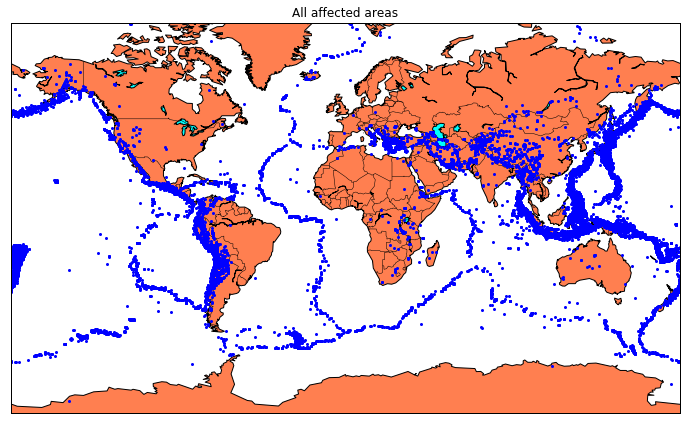

In [7]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
x,y = m(longitudes,latitudes)
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

# Split the data into X->features and y->targets

In [8]:
features = ['Timestamp', 'Latitude', 'Longitude']
targets = ['Magnitude', 'Depth']
X = final_data[features]
y = final_data[targets]

# Split the data to test and train portaions

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Create a model, and predict on the test data

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

best_model = None
best_score = 0

# I've tried running this model until the error rate stops improving, but it takes forever, so I'll revert it back to a finite loop first.
epsilon = 0.01
old_error = float('inf')
i = 1
while True:
    estimators = i*4
    model = RandomForestRegressor(n_estimators = estimators, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
    if abs(old_error - mse) <= epsilon:
        print(old_error)
        print(mse)
        print(old_error - mse)
        print("No improvement")
        break
    old_error = mse
    if best_score < score:
        best_score = score
        best_model = model
    i += 1

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


n_estimators=4:
	Mean Squared Error: 1343.5339053314572, 	R2 score: 0.25506913005942433, 	Model score: 0.8206263687201288
n_estimators=8:
	Mean Squared Error: 1191.5797854360812, 	R2 score: 0.3184764035687117, 	Model score: 0.8409135845212411
n_estimators=12:
	Mean Squared Error: 1149.4146337695145, 	R2 score: 0.33823413629785193, 	Model score: 0.8465430043206861
n_estimators=16:
	Mean Squared Error: 1106.5387838555444, 	R2 score: 0.3529374568511189, 	Model score: 0.8522673086071361
n_estimators=20:
	Mean Squared Error: 1107.272025064888, 	R2 score: 0.35865550233094046, 	Model score: 0.8521694144358002
n_estimators=24:
	Mean Squared Error: 1101.067752101512, 	R2 score: 0.3622492778860134, 	Model score: 0.8529977396209525
n_estimators=28:
	Mean Squared Error: 1108.8604441970822, 	R2 score: 0.36450401912447983, 	Model score: 0.8519573464659443
n_estimators=32:
	Mean Squared Error: 1115.8052907573924, 	R2 score: 0.36533623927499287, 	Model score: 0.8510301481710141
n_estimators=36:
	Mean 

# Model score

In [11]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
# max_err = max_error(y_pred, y_test)
r2 = r2_score(y_test, y_pred)
score = best_model.score(X_test, y_test)
print("Mean Squared Error:", mse)
print("R2 score:", r2)
print("Model score:", score)

Mean Squared Error: 1084.468866881065
R2 score: 0.3804343111362122
Model score: 0.8552138372611939


In [12]:
# # Create PNG files for each decision tree. Since each tree's depth is roughly 20, they're hard to visualize and harder to understand.
# # Lowering the max depth hurts the model score, as expected.
# # Running this bracket takes a long time.(Over an hour)

# from graphviz import render
# from IPython.display import Image
# from sklearn.tree import export_graphviz
# from subprocess import call
# for i, tree in enumerate(model.estimators_):
#     print(i)
#     export_graphviz(tree, out_file='{}.dot'.format(i), 
#                 feature_names = features,
#                 class_names = targets,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

#     call(['dot', '-Tpng', '{}.dot'.format(i), '-o', '{}.png'.format(i), '-Gdpi=600'])
